#**DowloadingLibraries**

In [ ]:
!pip install diffusers datasets

#**Kaggle JSON File**

In [ ]:
!mkdir  -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#**Importing Dataset**

In [ ]:
!kaggle datasets download -d mahmudulhaqueshawon/cat-image

#**UnzippingDataset**

In [4]:
from zipfile import ZipFile

cat_dataset = '/content/cat-image.zip'

with ZipFile(cat_dataset,'r') as zip:
  zip.extractall()
  print('File is extracted')


File is extracted


#**Importing Dependencies**

In [5]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import timeit

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

#**HyperPArameters**

In [6]:
# Define hyperparameters
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

# Set random seeds
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

#**LoadingDatset**

In [7]:
# Load the dataset and take a sample of 5000 images
dataset = load_dataset("imagefolder", data_dir="/content/cats", split="train")
dataset = Subset(dataset, random.sample(range(len(dataset)), 5000))

Resolving data files:   0%|          | 0/15747 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

#**PreProcessing**

In [8]:
# Define a transform function
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [9]:
def transform_dataset(dataset, transform):
    transformed_images = []
    for example in dataset:
        image = example["image"]
        transformed_images.append(transform(image.convert("RGB")))
    return transformed_images

In [10]:
# Apply the transform to the entire dataset
transformed_images = transform_dataset(dataset, preprocess)
transformed_dataset = [{"images": img} for img in transformed_images]

In [11]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_dataset, val_dataset = random_split(transformed_dataset, [train_size, val_size])

In [12]:
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

#**TrainingParameters**

In [13]:
# Define the model
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

#**AddingNoiseWithDDPMScheduler**

In [14]:
# Define noise scheduler and optimizer
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader) * NUM_EPOCHS
)


#**handle mixed precision trainingandgradient accumulation**

In [15]:
# Prepare with Accelerator
accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)


#**Image Generation Function**

In [16]:
# Function to generate sample images
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    fig = plt.figure()
    for i in range(1, num_generate_images + 1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i - 1])
    plt.show()

#**Model Training**

100%|██████████| 250/250 [03:01<00:00,  1.38it/s]


------------------------------
Train Loss EPOCH: 1: 0.2660
Val Loss EPOCH: 1: 0.0408
Train Learning Rate EPOCH: 1: 5e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

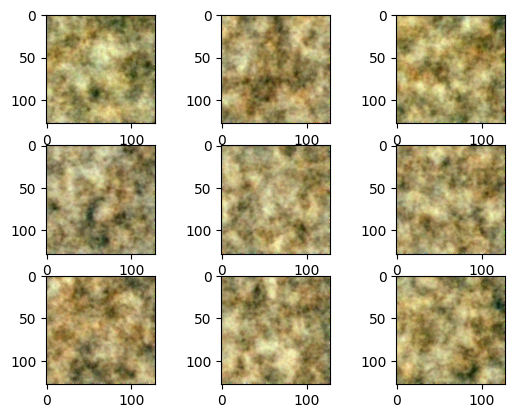

  2%|▏         | 1/50 [05:56<4:51:20, 356.75s/it]

------------------------------


  4%|▍         | 2/50 [09:14<3:30:27, 263.07s/it]

------------------------------
Train Loss EPOCH: 2: 0.0293
Val Loss EPOCH: 2: 0.0225
Train Learning Rate EPOCH: 2: 0.0001
------------------------------


  6%|▌         | 3/50 [12:32<3:02:44, 233.28s/it]

------------------------------
Train Loss EPOCH: 3: 0.0189
Val Loss EPOCH: 3: 0.0179
Train Learning Rate EPOCH: 3: 9.989294616193017e-05
------------------------------


  8%|▊         | 4/50 [15:50<2:48:16, 219.48s/it]

------------------------------
Train Loss EPOCH: 4: 0.0147
Val Loss EPOCH: 4: 0.0118
Train Learning Rate EPOCH: 4: 9.957224306869053e-05
------------------------------


 10%|█         | 5/50 [19:07<2:38:37, 211.51s/it]

------------------------------
Train Loss EPOCH: 5: 0.0132
Val Loss EPOCH: 5: 0.0123
Train Learning Rate EPOCH: 5: 9.903926402016153e-05
------------------------------


 12%|█▏        | 6/50 [22:25<2:31:35, 206.73s/it]

------------------------------
Train Loss EPOCH: 6: 0.0117
Val Loss EPOCH: 6: 0.0125
Train Learning Rate EPOCH: 6: 9.829629131445342e-05
------------------------------


 14%|█▍        | 7/50 [25:42<2:26:00, 203.73s/it]

------------------------------
Train Loss EPOCH: 7: 0.0121
Val Loss EPOCH: 7: 0.0144
Train Learning Rate EPOCH: 7: 9.73465064747553e-05
------------------------------


 16%|█▌        | 8/50 [28:59<2:21:09, 201.64s/it]

------------------------------
Train Loss EPOCH: 8: 0.0115
Val Loss EPOCH: 8: 0.0105
Train Learning Rate EPOCH: 8: 9.619397662556435e-05
------------------------------


 18%|█▊        | 9/50 [32:17<2:16:51, 200.29s/it]

------------------------------
Train Loss EPOCH: 9: 0.0110
Val Loss EPOCH: 9: 0.0120
Train Learning Rate EPOCH: 9: 9.484363707663442e-05
------------------------------


 20%|██        | 10/50 [35:34<2:12:54, 199.35s/it]

------------------------------
Train Loss EPOCH: 10: 0.0115
Val Loss EPOCH: 10: 0.0108
Train Learning Rate EPOCH: 10: 9.330127018922194e-05
------------------------------


100%|██████████| 250/250 [03:00<00:00,  1.38it/s]


------------------------------
Train Loss EPOCH: 11: 0.0110
Val Loss EPOCH: 11: 0.0126
Train Learning Rate EPOCH: 11: 9.157348061512727e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

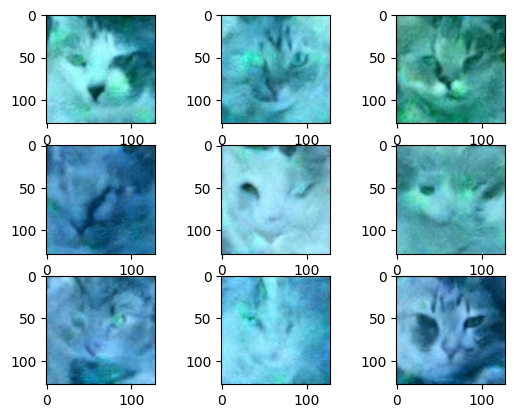

 22%|██▏       | 11/50 [41:29<2:40:33, 247.02s/it]

------------------------------


 24%|██▍       | 12/50 [44:47<2:26:56, 232.02s/it]

------------------------------
Train Loss EPOCH: 12: 0.0107
Val Loss EPOCH: 12: 0.0106
Train Learning Rate EPOCH: 12: 8.966766701456177e-05
------------------------------


 26%|██▌       | 13/50 [48:04<2:16:37, 221.55s/it]

------------------------------
Train Loss EPOCH: 13: 0.0105
Val Loss EPOCH: 13: 0.0106
Train Learning Rate EPOCH: 13: 8.759199037394887e-05
------------------------------


 28%|██▊       | 14/50 [51:22<2:08:33, 214.25s/it]

------------------------------
Train Loss EPOCH: 14: 0.0104
Val Loss EPOCH: 14: 0.0089
Train Learning Rate EPOCH: 14: 8.535533905932738e-05
------------------------------


 30%|███       | 15/50 [54:39<2:02:02, 209.21s/it]

------------------------------
Train Loss EPOCH: 15: 0.0103
Val Loss EPOCH: 15: 0.0101
Train Learning Rate EPOCH: 15: 8.296729075500344e-05
------------------------------


 32%|███▏      | 16/50 [57:57<1:56:33, 205.70s/it]

------------------------------
Train Loss EPOCH: 16: 0.0096
Val Loss EPOCH: 16: 0.0106
Train Learning Rate EPOCH: 16: 8.043807145043604e-05
------------------------------


 34%|███▍      | 17/50 [1:01:15<1:51:51, 203.39s/it]

------------------------------
Train Loss EPOCH: 17: 0.0104
Val Loss EPOCH: 17: 0.0132
Train Learning Rate EPOCH: 17: 7.777851165098012e-05
------------------------------


 36%|███▌      | 18/50 [1:04:32<1:47:33, 201.66s/it]

------------------------------
Train Loss EPOCH: 18: 0.0100
Val Loss EPOCH: 18: 0.0095
Train Learning Rate EPOCH: 18: 7.500000000000001e-05
------------------------------


 38%|███▊      | 19/50 [1:07:54<1:44:10, 201.64s/it]

------------------------------
Train Loss EPOCH: 19: 0.0098
Val Loss EPOCH: 19: 0.0105
Train Learning Rate EPOCH: 19: 7.211443451095007e-05
------------------------------


 40%|████      | 20/50 [1:11:15<1:40:43, 201.44s/it]

------------------------------
Train Loss EPOCH: 20: 0.0104
Val Loss EPOCH: 20: 0.0096
Train Learning Rate EPOCH: 20: 6.91341716182545e-05
------------------------------


100%|██████████| 250/250 [03:03<00:00,  1.36it/s]


------------------------------
Train Loss EPOCH: 21: 0.0098
Val Loss EPOCH: 21: 0.0107
Train Learning Rate EPOCH: 21: 6.607197326515808e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

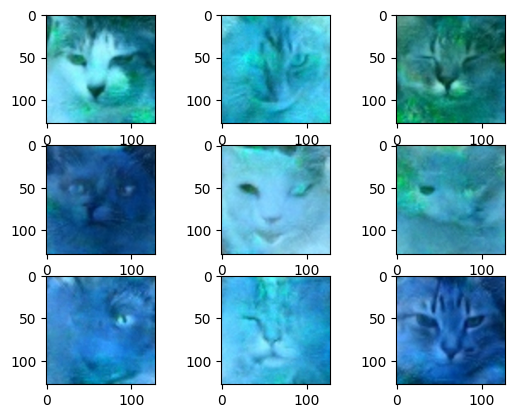

 42%|████▏     | 21/50 [1:17:22<2:01:18, 250.99s/it]

------------------------------


 44%|████▍     | 22/50 [1:20:40<1:49:49, 235.32s/it]

------------------------------
Train Loss EPOCH: 22: 0.0096
Val Loss EPOCH: 22: 0.0098
Train Learning Rate EPOCH: 22: 6.294095225512603e-05
------------------------------


 46%|████▌     | 23/50 [1:23:58<1:40:49, 224.07s/it]

------------------------------
Train Loss EPOCH: 23: 0.0098
Val Loss EPOCH: 23: 0.0098
Train Learning Rate EPOCH: 23: 5.9754516100806423e-05
------------------------------


 48%|████▊     | 24/50 [1:27:16<1:33:40, 216.18s/it]

------------------------------
Train Loss EPOCH: 24: 0.0095
Val Loss EPOCH: 24: 0.0084
Train Learning Rate EPOCH: 24: 5.6526309611002594e-05
------------------------------


 50%|█████     | 25/50 [1:30:34<1:27:48, 210.73s/it]

------------------------------
Train Loss EPOCH: 25: 0.0096
Val Loss EPOCH: 25: 0.0095
Train Learning Rate EPOCH: 25: 5.327015646150716e-05
------------------------------


 52%|█████▏    | 26/50 [1:33:55<1:23:05, 207.72s/it]

------------------------------
Train Loss EPOCH: 26: 0.0090
Val Loss EPOCH: 26: 0.0101
Train Learning Rate EPOCH: 26: 5e-05
------------------------------


 54%|█████▍    | 27/50 [1:37:15<1:18:43, 205.38s/it]

------------------------------
Train Loss EPOCH: 27: 0.0095
Val Loss EPOCH: 27: 0.0101
Train Learning Rate EPOCH: 27: 4.6729843538492847e-05
------------------------------


 56%|█████▌    | 28/50 [1:40:32<1:14:28, 203.10s/it]

------------------------------
Train Loss EPOCH: 28: 0.0090
Val Loss EPOCH: 28: 0.0090
Train Learning Rate EPOCH: 28: 4.347369038899744e-05
------------------------------


 58%|█████▊    | 29/50 [1:43:50<1:10:32, 201.55s/it]

------------------------------
Train Loss EPOCH: 29: 0.0093
Val Loss EPOCH: 29: 0.0102
Train Learning Rate EPOCH: 29: 4.0245483899193595e-05
------------------------------


 60%|██████    | 30/50 [1:47:08<1:06:49, 200.50s/it]

------------------------------
Train Loss EPOCH: 30: 0.0097
Val Loss EPOCH: 30: 0.0092
Train Learning Rate EPOCH: 30: 3.705904774487396e-05
------------------------------


100%|██████████| 250/250 [03:01<00:00,  1.38it/s]


------------------------------
Train Loss EPOCH: 31: 0.0092
Val Loss EPOCH: 31: 0.0101
Train Learning Rate EPOCH: 31: 3.392802673484193e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

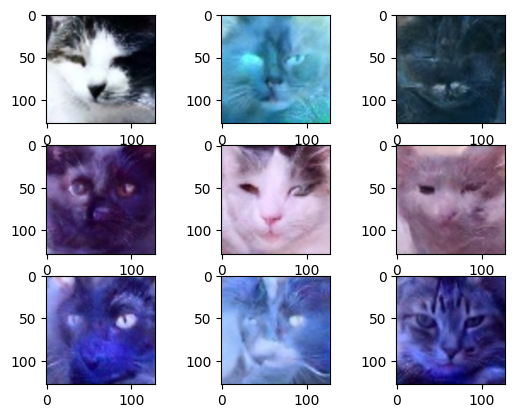

 62%|██████▏   | 31/50 [1:53:04<1:18:15, 247.16s/it]

------------------------------


 64%|██████▍   | 32/50 [1:56:22<1:09:43, 232.43s/it]

------------------------------
Train Loss EPOCH: 32: 0.0090
Val Loss EPOCH: 32: 0.0094
Train Learning Rate EPOCH: 32: 3.086582838174551e-05
------------------------------


 66%|██████▌   | 33/50 [1:59:40<1:02:55, 222.12s/it]

------------------------------
Train Loss EPOCH: 33: 0.0091
Val Loss EPOCH: 33: 0.0094
Train Learning Rate EPOCH: 33: 2.7885565489049946e-05
------------------------------


 11%|█         | 27/250 [00:19<02:42,  1.37it/s]

In [ ]:
# Training and validation loop with loss tracking
train_losses = []
val_losses = []

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)
    train_losses.append(train_loss)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, batch in enumerate(val_dataloader):
            clean_images = batch["images"].to(device)
            noise = torch.randn(clean_images.shape).to(device)
            last_batch_size = len(clean_images)

            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)

            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)
    val_losses.append(val_loss)

    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-" * 30)
    print(f"Train Loss EPOCH: {epoch + 1}: {train_loss:.4f}")
    print(f"Val Loss EPOCH: {epoch + 1}: {val_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch + 1}: {train_learning_rate}")
    if epoch % 10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-" * 30)

stop = timeit.default_timer()
print(f"Training Time: {stop - start:.2f}s")

#**Plotting Train and VAl loss convergence**

In [ ]:
# Plot the training and validation loss convergence
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_EPOCHS), train_losses, label='Training Loss')
plt.plot(range(NUM_EPOCHS), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Convergence')
plt.legend()
plt.show()
